Our goal is to predict weekly return of MSFT stock with an assumption that there are 5 trading days in a week

# Importing the Libraries/Fuctions

### Supervised Algorithms

In [1]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet)

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from sklearn.neural_network import MLPRegressor

### Data Analysis and Model Evaluation

In [2]:
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import (
    SelectKBest,
    chi2,
    f_regression
)

### Deep learning Modules

In [3]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor

2023-10-19 10:43:43.100094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Time Series Model

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

### Data Preparation and Visualization

In [5]:
import numpy as np
import pandas as pd 
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

### Parameters

In [6]:
# importing yfin pdr override to get ride of an type error
import yfinance as yfin
yfin.pdr_override()

# For Datetime
import datetime as dt
start = dt.datetime(2005, 1, 1)
end = dt.datetime.now()
weekly_return_period = 5

validation_size = 0.2
num_folds = 10 # Ten fold Cross Validation to account for inherent randomness in some models & CV process
scoring = 'neg_mean_squared_error' # for evaluation
seed = 16

# Load the data

In [7]:

# Getting Microsoft, IBM, and Google data from yahoo finance
stk_tickers = ['MSFT','IBM','GOOGL']
stk_data = web.get_data_yahoo(stk_tickers,start,end)

# Getting the Japan US Exchange rate & US UK exchange rate
ccy_tickers = ['DEXJPUS','DEXUSUK']
ccy_data = web.get_data_fred(ccy_tickers,start,end)

# Getting the index data
idx_tickers = ['SP500','DJIA','VIXCLS']
idx_data = web.get_data_fred(idx_tickers,start,end)

[*********************100%%**********************]  3 of 3 completed


In [8]:
# Now let's find the 5 day lagged return 

def find_lagged_return(data: pd.DataFrame, ticker:str,shift_period: int = None, return_period:int = 5) -> pd.Series:
    if shift_period:
        return np.log(data.loc[:,ticker]).diff(return_period).shift(-return_period)
    else:
        return np.log(data.loc[:,ticker]).diff(return_period)
    
# find the value to be predicted, i.e., MSFT weekly return
Y = find_lagged_return(stk_data,('Adj Close','MSFT'),weekly_return_period,weekly_return_period)
Y.name = Y.name[-1] + '_pred'

# get the weekly return of google and ibm data
X1 = find_lagged_return(stk_data,('Adj Close',('GOOGL','IBM')),None,weekly_return_period)
X1.columns = X1.columns.droplevel()

# get the index and currency returns
X2 = np.log(ccy_data).diff(weekly_return_period)
X3 = np.log(idx_data).diff(weekly_return_period)

# get the msft data for weekly period* [1,3,6,12] 
X4 = pd.concat([ find_lagged_return(stk_data,('Adj Close',('MSFT')),None,i) \
                for i in [weekly_return_period, 
                    weekly_return_period*3, # 15 days if weekly_return_period is 5
                    weekly_return_period*6, # 30 days if weekly_return_period is 5
                    weekly_return_period*12, # 60 days if weekly_return_period is 5
                    weekly_return_period*18, # 90 days if weekly_return_period is 5                    
                    ] ], axis = 1).dropna()
X4.columns = ['MSFT_DT','MSFT_3DT','MSFT_6DT','MSFT_12DT','MSFT_18DT']

# Let's merge them all
X = pd.concat([X1,X2,X3,X4],axis = 1 )
print(f"X has minimum date of {min(X.index)} and maximum date of {max(X.index)}")

# Let's create the dataset and remove all the rows containing NA in either of the column
dataset = pd.concat([Y,X], axis=1).dropna().iloc[::weekly_return_period, :]

Y = dataset[[Y.name]]
X = dataset[X.columns]

X has minimum date of 2005-01-03 00:00:00 and maximum date of 2023-10-18 00:00:00


In [9]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_18DT
2013-10-28,0.010348,0.011594,0.025643,-0.004493,-0.001115,0.009952,0.011416,0.011334,0.016440,0.065945,0.081074,0.116232,0.067277
2013-11-04,0.044887,0.010886,0.016331,0.009373,-0.011284,0.003297,0.004498,-0.028965,0.010348,0.042342,0.093253,0.101497,0.044441
2013-11-12,-0.009179,-0.009581,0.034284,0.010593,-0.008010,0.002674,0.008445,-0.034499,0.019460,0.077325,0.106670,0.174111,0.091603
2013-11-20,0.013926,-0.009889,0.008895,0.007124,0.007271,-0.000354,0.004993,0.067927,-0.021154,0.049975,0.122007,0.116278,0.036664
2013-11-27,0.010582,0.039134,-0.034164,0.021366,0.007218,0.014413,0.012283,-0.031845,0.013926,-0.007752,0.089551,0.194141,0.181487


### Exploratory Data Analysis

<Axes: title={'center': 'Correlation Matrix'}>

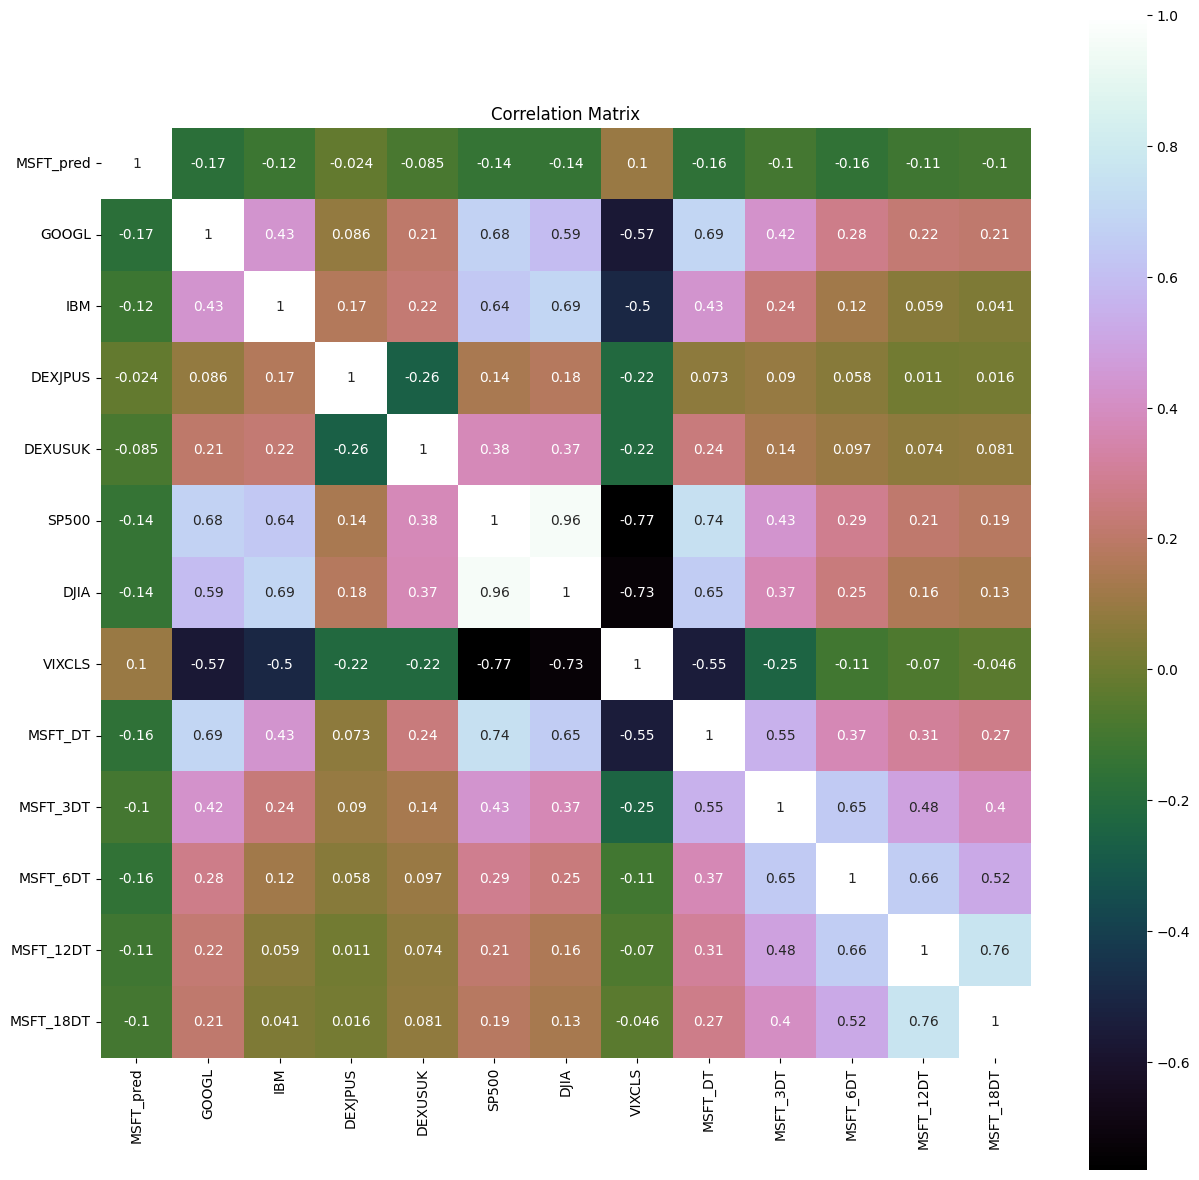

In [10]:
# Let's try to viz the correlation matrix
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

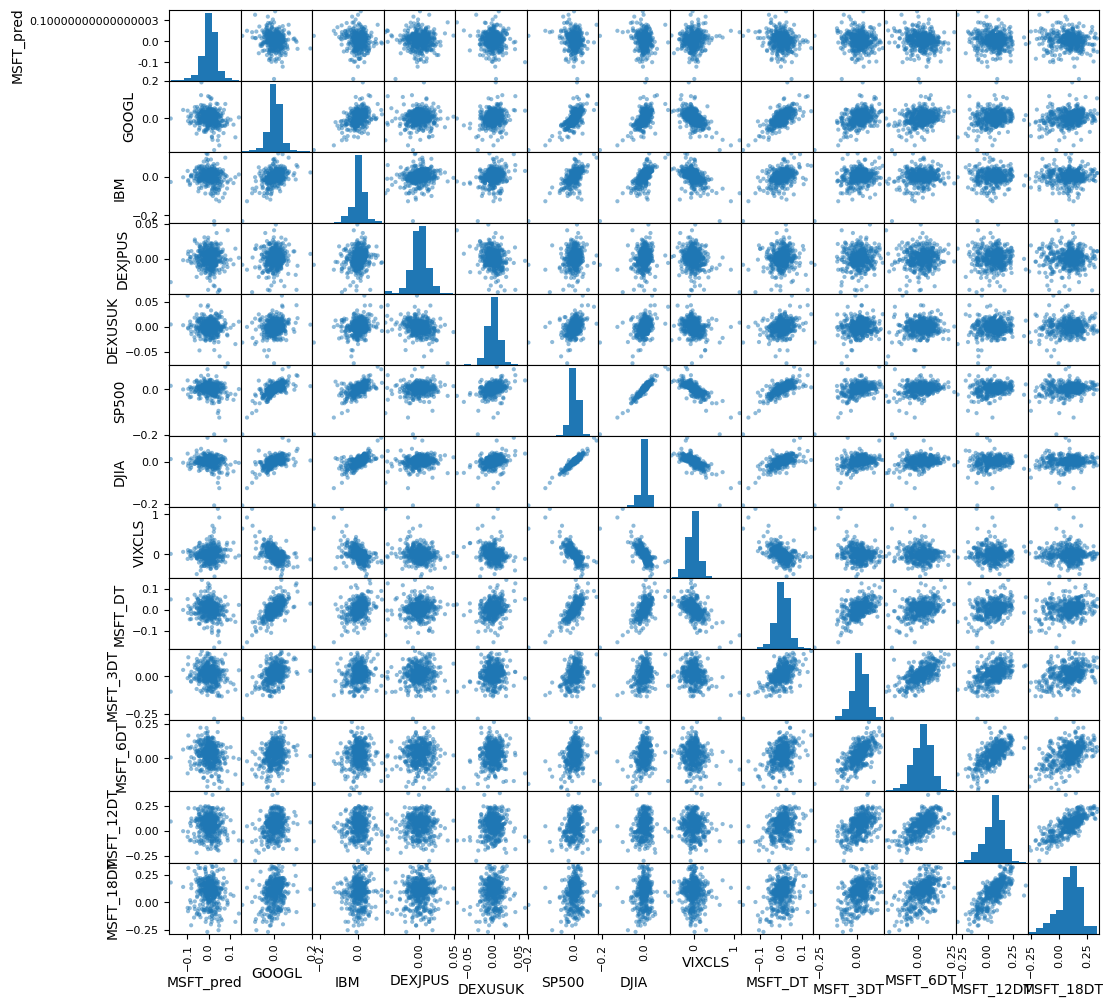

In [11]:
# Let's try a scatterplot matrix to viz relationship between all variables in the regression
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

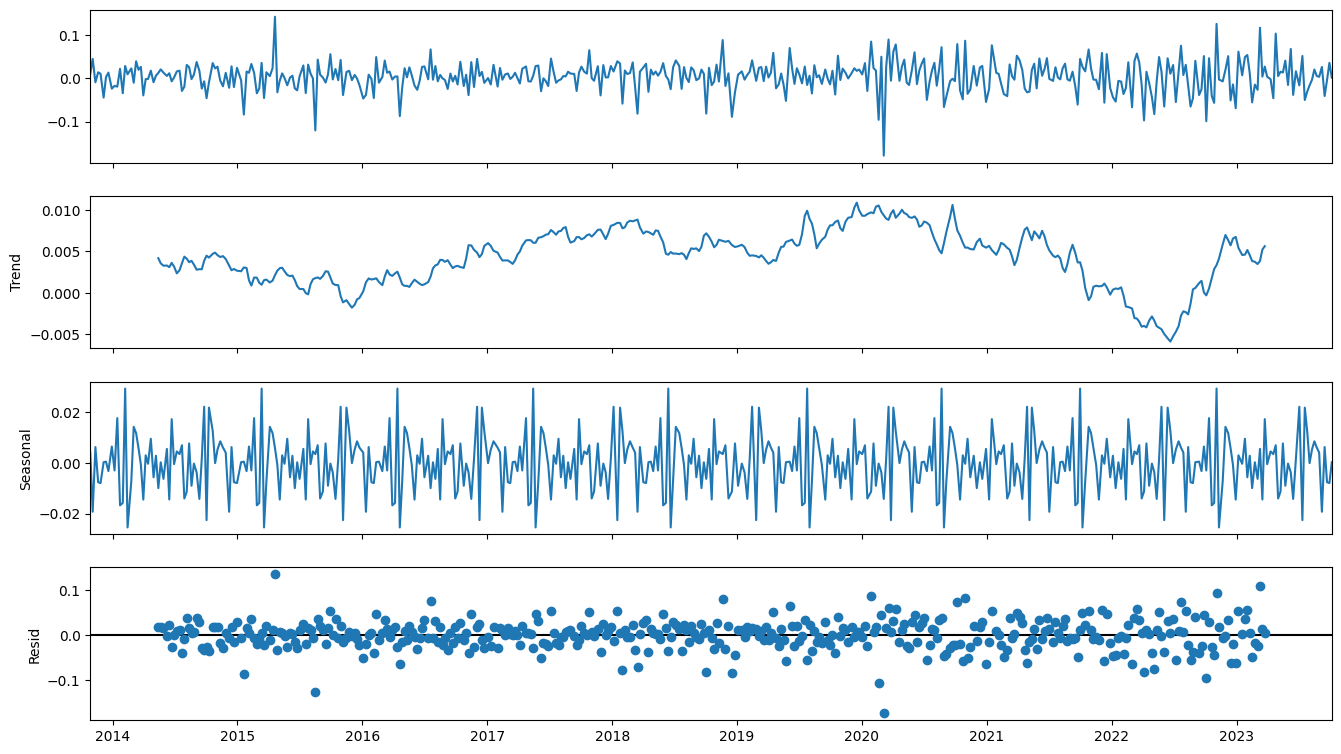

In [12]:
# Time series analysis 

res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

### Data Preparation 

In [13]:
train_size = int(len(X) * (1-validation_size) )
# Note - not doing a random split because we want to do a prediction in future based on previous sequence; so ordered data is must
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### Models

In [14]:
models = []
# Regression and tree based models
models.append( ('LR',LinearRegression()) )
models.append( ('LASSO',Lasso()) )
models.append( ('EN',ElasticNet()) )
models.append( ('KNN',KNeighborsRegressor()) )
models.append( ('CART',DecisionTreeRegressor()) )
models.append( ('SVR',SVR()) )
# neural net
models.append( ('MLP',MLPRegressor()) )
# Ensemble
## Boosting 
models.append( ('ABR',AdaBoostRegressor()) )
models.append( ('GBR',GradientBoostingRegressor()) )
## Bagging
models.append( ('RFR',RandomForestRegressor()) )
models.append( ('ETR',ExtraTreesRegressor()) )


In [15]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models: 
    names.append(name)
    
    # K Fold Analysis 
    kfold =  KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # converted mean squared error to positive; the lower the better
    cv_results = -1*cross_val_score(model, X_train,np.ravel(Y_train,order='C'), cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    # Full training period 
    res = model.fit(X_train, np.ravel(Y_train,order='C') )
    train_result = mean_squared_error( res.predict(X_train), np.ravel(Y_train,order='C') )
    train_results.append(train_result)
    # Test Results 
    test_result = mean_squared_error( res.predict(X_test), np.ravel(Y_test,order='C') )
    test_results.append(test_result)
    


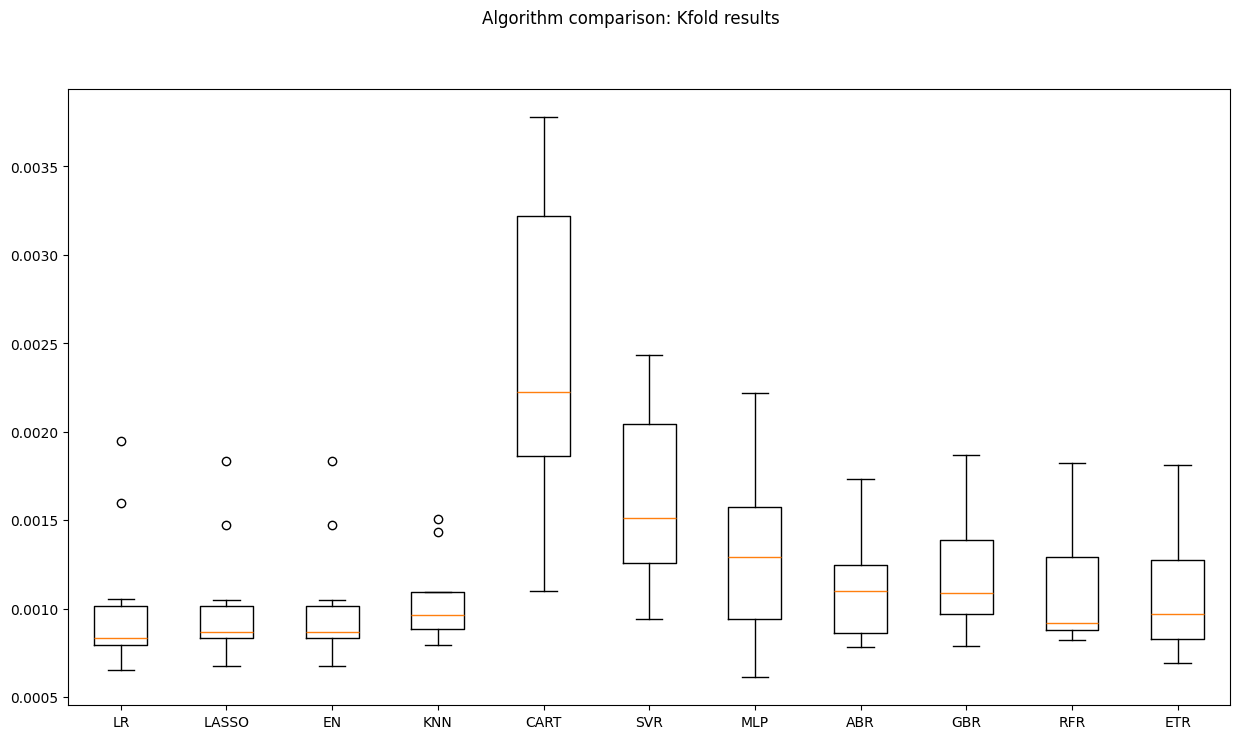

In [16]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

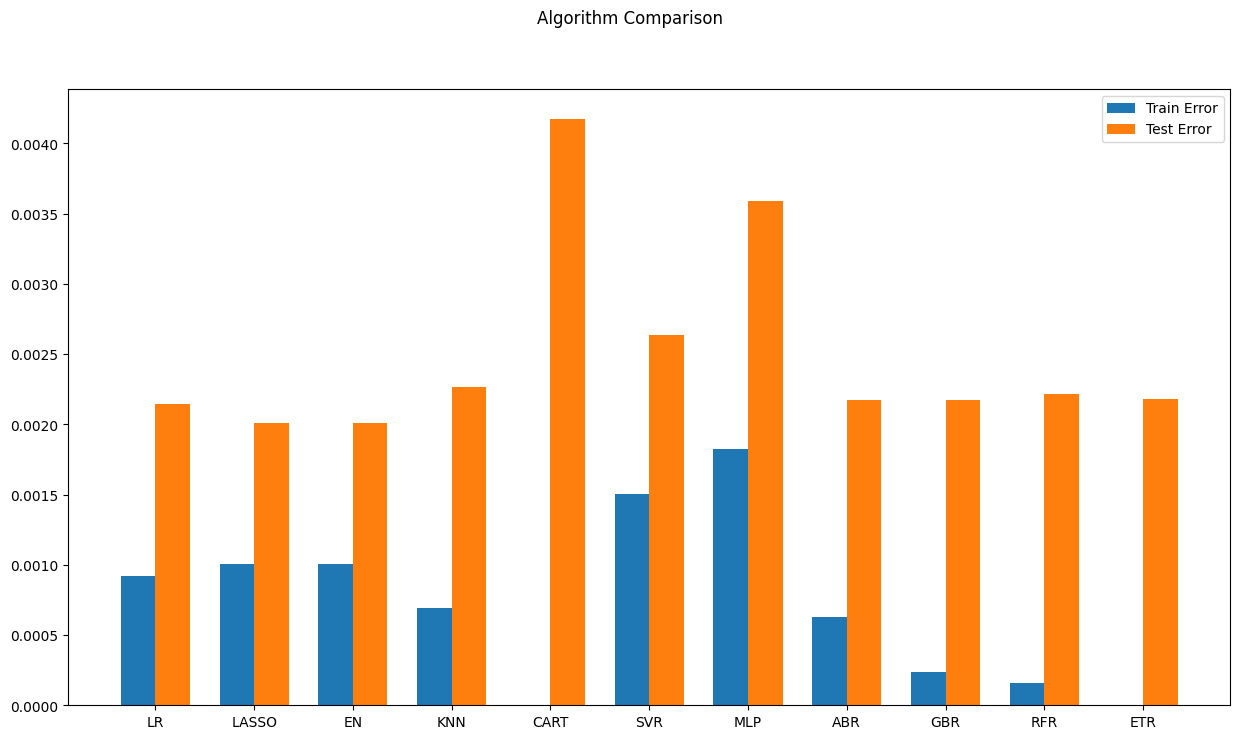

In [17]:
# Let's look at errors of the test set as well 
fig = pyplot.figure()

ind = np.arange(len(names)) # the x locations of the groups
width = 0.35  # width of bars

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label="Train Error")
pyplot.bar(ind + width/2, test_results, width=width, label="Test Error")
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

## Time Series Models

### ARIMA

In [18]:
# Let's only take exogenous variables
X_train_ARIMA = X_train[['GOOGL', 'IBM', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test[['GOOGL', 'IBM', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

# convert the index datetime index with frequency
X_train_ARIMA.index = pd.DatetimeIndex(X_train_ARIMA.index).to_period('W')
X_test_ARIMA.index = pd.DatetimeIndex(X_test_ARIMA.index).to_period('W')
Y_train_ARIMA = Y_train.copy()
Y_train_ARIMA.index = pd.DatetimeIndex(Y_train_ARIMA.index).to_period('W')
Y_test_ARIMA = Y_test.copy()
Y_test_ARIMA.index = pd.DatetimeIndex(Y_test_ARIMA.index).to_period('W')

# Let's create a model and fit it 
modelARIMA = ARIMA(endog=Y_train_ARIMA, exog = X_train_ARIMA, order=[1,0,0]) 
model_fit = modelARIMA.fit()
error_Training_ARIMA = mean_squared_error(Y_train_ARIMA,model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len - 1, end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
error_Test_ARIMA


/Users/adityavyas/Desktop/AWS/MachineLearningProjects/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0020031112627149545

### LSTM model

In [19]:
# data prep
seq_len = 2 
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len,seq_len,X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0],seq_len,X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:,i,:] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len,:]
    X_test_LSTM[:,i,:] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len,:]


In [20]:
# LSTM Network

def create_LSTModel(learn_rate = 0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(50, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2])))
    # more cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse',optimizer='adam')
    return model 
    
LSTMModel = create_LSTModel(learn_rate=0.01,momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, 
                                Y_train_LSTM, 
                                validation_data=(X_test_LSTM,Y_test_LSTM),
                                epochs = 330,
                                batch_size=72,
                                    verbose=0,
                                    shuffle=False )

2023-10-19 10:44:29.184053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-19 10:44:29.188212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-19 10:44:29.189972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

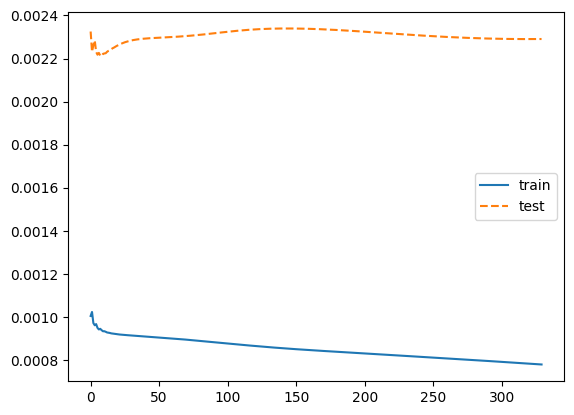

In [21]:
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test')
pyplot.legend()
pyplot.show()


In [22]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append('ARIMA')
names.append("LSTM")



 1/12 [=>............................] - ETA: 4s

2023-10-19 10:44:47.297200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-19 10:44:47.298812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-19 10:44:47.300252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 12ms/step


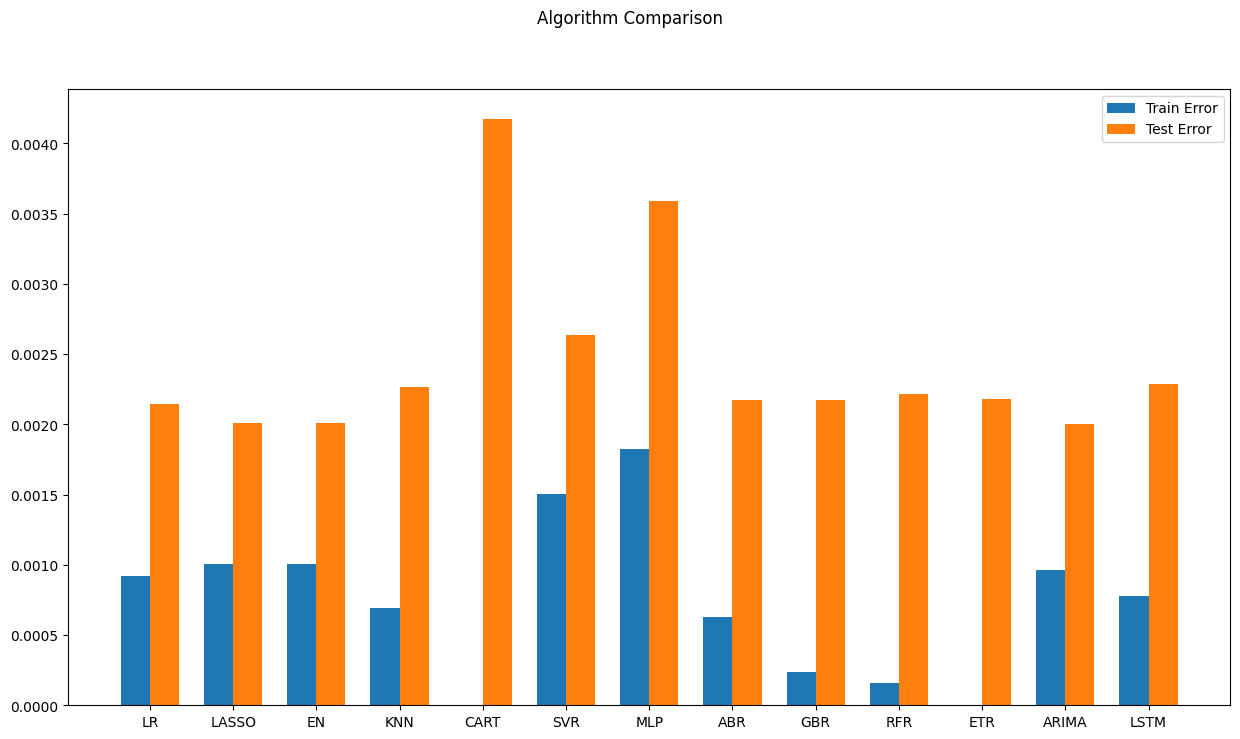

In [23]:
# Let's look at errors of the test set as well 
fig = pyplot.figure()

ind = np.arange(len(names)) # the x locations of the groups
width = 0.35  # width of bars

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label="Train Error")
pyplot.bar(ind + width/2, test_results, width=width, label="Test Error")
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [24]:
# ARIMA performed similar to supervised LASSO and EN and performed better then LSTM so choosing it for Tuning

# Model Tuning

In [25]:
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA = ARIMA(endog=Y_train_ARIMA, exog = X_train_ARIMA, order = arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train_ARIMA, model_fit.fittedvalues)
    return error

def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try: 
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order 
                    print(f'ARIMA {order} MSE {mse}')
                except:
                    continue 
    print(f'Best ARIMA {best_cfg} MSE {best_score}')
    return best_cfg

import warnings
warnings.filterwarnings("ignore")
ord = evaluate_models(range(0,3),range(0,2),range(0,2))

ARIMA (0, 0, 0) MSE 0.0009676164293018905
ARIMA (0, 0, 1) MSE 0.0009599897905694928
ARIMA (0, 1, 0) MSE 0.0017983486415787352
ARIMA (0, 1, 1) MSE 0.00098154235550899
ARIMA (1, 0, 0) MSE 0.0009619532419460909
ARIMA (1, 0, 1) MSE 0.0009429056090685504
ARIMA (1, 1, 0) MSE 0.0015017349445181562
ARIMA (1, 1, 1) MSE 0.0009920101589919262
ARIMA (2, 0, 0) MSE 0.0009578850323195681
ARIMA (2, 0, 1) MSE 0.0009551127676859897
ARIMA (2, 1, 0) MSE 0.0013260775226514177
ARIMA (2, 1, 1) MSE 0.0010035303564940483
Best ARIMA (1, 0, 1) MSE 0.0009429056090685504


# Final Tuned Model 

In [26]:
modelARIMA_tuned =  ARIMA(endog=Y_train_ARIMA, exog = X_train_ARIMA, order = ord)
model_fit_tuned = modelARIMA_tuned.fit()

# estiamte accuracy on validation set 
predicted_tuned = model_fit.predict(start = tr_len - 1, end = to_len - 1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test_ARIMA,predicted_tuned))

0.0020031112627149545


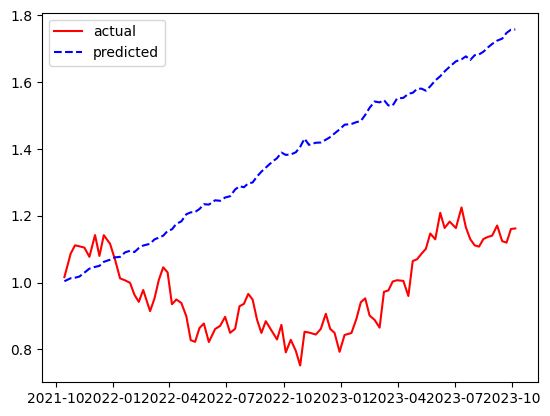

In [27]:
# plotting the actual data vs predicted data 
predicted_tuned.index = Y_test.index 
pyplot.plot(np.exp(Y_test).cumprod(),'r',label='actual',)

# plotting t, a separately 
pyplot.plot(np.exp(predicted_tuned).cumprod(),'b--',label='predicted',)
pyplot.legend()
pyplot.rcParams["figure.figsize"]=(8,5)
pyplot.show()